In [1]:
!python -m spacy download pl_core_news_sm
!python -m spacy download en_core_web_sm
!pip install evaluate

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 66.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart run

In [2]:
# ====== Core ======
import os
import random
from dataclasses import dataclass
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# ====== Numerical ======
import numpy as np
import pandas as pd

# ====== PyTorch ======
import torch
import torch.nn as nn
import torch.optim as optim

# ====== Data / progress ======
import datasets
from collections import Counter
from tqdm import tqdm

# (опційно) метрики для BLEU/chrF тощо, якщо будеш рахувати
import evaluate

# (опційно) токенізація
import spacy

# (опційно) графіки loss
import matplotlib.pyplot as plt
import random

# ====== Reproducibility ======
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA:", torch.cuda.is_available(), "| device:", device)
print("torch:", torch.__version__)


E0000 00:00:1767170135.213773      80 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767170135.257566      80 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767170135.614288      80 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767170135.614335      80 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767170135.614340      80 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767170135.614345      80 computation_placer.cc:177] computation placer already registered. Please check linka

CUDA: True | device: cuda
torch: 2.8.0+cu126


In [3]:
dataset = datasets.load_dataset("Helsinki-NLP/europarl", "en-pl")

dataset


README.md: 0.00B [00:00, ?B/s]

en-pl/train-00000-of-00001.parquet:   0%|          | 0.00/114M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/631160 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 631160
    })
})

In [4]:
seed = 42
full = dataset["train"].shuffle(seed=seed)

N = 100_000
full_small = full.select(range(N))
full = full_small
# 80% train, 20% (valid+test)
tmp = full.train_test_split(test_size=0.2, seed=seed, shuffle=True)
train_data = tmp["train"]
tmp2 = tmp["test"].train_test_split(test_size=0.5, seed=seed, shuffle=True)

valid_data = tmp2["train"]  # 10%
test_data  = tmp2["test"]   # 10%

print(len(train_data), len(valid_data), len(test_data))

80000 10000 10000


In [5]:
with pd.option_context('display.max_colwidth', None):
    example_df = pd.DataFrame(train_data[:5])
    display(example_df)

,translation
0,"{'en': 'Since this is a very serious problem that puts public health in the EU at risk, I believe the implementation of new rules is key to protecting patients from falsified medicinal products.', 'pl': 'Ponieważ chodzi o bardzo poważny problem, który wiąże się z ryzykiem dla zdrowia publicznego w UE, uważam, że wdrożenie nowych przepisów ma kluczowe znaczenie dla ochrony pacjentów przed sfałszowanymi produktami leczniczymi.'}"
1,"{'en': 'Decisions concerning certain documents: see Minutes', 'pl': 'Decyzje dotyczące niektórych dokumentów: patrz protokół'}"
2,"{'en': 'Slovak is one of the most beautiful languages in Europe but it is seldom heard in the European Parliament.', 'pl': 'Słowacki jest jednym z najpiękniejszych języków w Europie, ale rzadko mamy okazję słyszeć ten język w Parlamencie Europejskim.'}"
3,"{'en': 'It would therefore be wrong to simply portray increased trade openness as a mere lose-lose scenario for EU agriculture.', 'pl': 'Błędem z mojej strony byłoby zatem przedstawianie większej otwartości w obszarze handlu jedynie w formie zwykłego scenariusza dla rolnictwa UE.'}"
4,"{'en': 'Until this has been achieved, the success of any EU strategy will have a limited effect.', 'pl': 'Dopóki tego nie zrealizujemy, powodzenie dowolnej strategii UE będzie miało ograniczony skutek.'}"


In [6]:
en_nlp = spacy.load("en_core_web_sm")
pl_nlp = spacy.load("pl_core_news_sm")

In [7]:
def tokenize_example(    
    example,
    en_nlp,
    pl_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["translation"]["en"])][:max_length]
    pl_tokens = [token.text for token in pl_nlp.tokenizer(example["translation"]["pl"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        pl_tokens = [token.lower() for token in pl_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    pl_tokens = [sos_token] + pl_tokens + [eos_token]
    return {"en_tokens": en_tokens, "pl_tokens": pl_tokens}

In [8]:
max_length = 200
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "pl_nlp": pl_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

len(train_data[0]["en_tokens"]), len(train_data[0]["pl_tokens"])

# train_data[0]["en_tokens"][:30]
# train_data[0]["pl_tokens"][:30]

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

(36, 37)

In [9]:
class SimpleVocab:
    def __init__(self, tokens_iter, min_freq, specials):
        counter = Counter()
        for tokens in tokens_iter:
            counter.update(tokens)

        # specials йдуть першими, порядок важливий
        itos = []
        seen = set()
        for sp in specials:
            if sp not in seen:
                itos.append(sp)
                seen.add(sp)

        # далі всі токени, що зустрілись >= min_freq
        for tok, freq in counter.items():
            if freq >= min_freq and tok not in seen:
                itos.append(tok)
                seen.add(tok)

        self.itos = itos
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}
        self._default_index = None

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        idx = self.stoi.get(token)
        if idx is None:
            if self._default_index is None:
                raise KeyError(token)
            return self._default_index
        return idx

    def get_itos(self):
        return self.itos

    def set_default_index(self, idx):
        self._default_index = idx

    def lookup_indices(self, tokens):
        return [self[t] for t in tokens]

In [10]:
min_freq = 4
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [unk_token, pad_token, sos_token, eos_token]

en_vocab = SimpleVocab(train_data["en_tokens"], min_freq=min_freq, specials=special_tokens)
pl_vocab = SimpleVocab(train_data["pl_tokens"], min_freq=min_freq, specials=special_tokens)

In [11]:
assert en_vocab[unk_token] == pl_vocab[unk_token]
assert en_vocab[pad_token] == pl_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])
print(en_vocab.get_itos()[30])

0
1
16
patients


In [12]:
en_vocab.set_default_index(en_vocab[unk_token])
pl_vocab.set_default_index(pl_vocab[unk_token])

In [13]:
def numericalize_example(example, en_vocab, pl_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    pl_ids = pl_vocab.lookup_indices(example["pl_tokens"])
    return {"en_ids": en_ids, "pl_ids": pl_ids}

In [14]:
fn_kwargs = {
    "en_vocab": en_vocab, 
    "pl_vocab": pl_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

train_data[0]["en_ids"]
train_data[0]["pl_ids"]


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

[2,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 10,
 21,
 10,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 16,
 29,
 30,
 31,
 32,
 33,
 0,
 34,
 3]

In [15]:
# data_type = "torch"
# format_columns = ["en_ids", "pl_ids"]

# train_data = train_data.with_format(
#     type=data_type, 
#     columns=format_columns, 
#     output_all_columns=True
# )

# valid_data = valid_data.with_format(
#     type=data_type, 
#     columns=format_columns, 
#     output_all_columns=True,
# )

# test_data = test_data.with_format(
#     type=data_type, 
#     columns=format_columns, 
#     output_all_columns=True,
# )

# train_data


In [16]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [torch.tensor(ex["en_ids"], dtype=torch.long) for ex in batch]
        batch_pl_ids = [torch.tensor(ex["pl_ids"], dtype=torch.long) for ex in batch]

        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_pl_ids = nn.utils.rnn.pad_sequence(batch_pl_ids, padding_value=pad_index)

        return {"en_ids": batch_en_ids, "pl_ids": batch_pl_ids}
    return collate_fn

In [17]:
# def get_collate_fn(pad_index):
#     '''
#     Adding padding as a part of a collate_fn.
#     '''
    
#     def collate_fn(batch):
#         batch_en_ids = [example["en_ids"] for example in batch]
#         batch_pl_ids = [example["pl_ids"] for example in batch]
#         batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index).long()
#         batch_pl_ids = nn.utils.rnn.pad_sequence(batch_pl_ids, padding_value=pad_index).long()
#         batch = {
#             "en_ids": batch_en_ids,
#             "pl_ids": batch_pl_ids,
#         }
#         return batch
    
#     return collate_fn


In [18]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    
    collate_fn = get_collate_fn(pad_index)
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader


In [19]:
batch_size = 32

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

next(iter(train_data_loader))


{'en_ids': tensor([[  2,   2,   2,  ...,   2,   2,   2],
         [ 16,   5,  88,  ..., 554,  15,  88],
         [621, 878, 147,  ..., 599, 234, 147],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]]),
 'pl_ids': tensor([[    2,     2,     2,  ...,     2,     2,     2],
         [ 1085,  3885,   666,  ...,   688,     0, 12340],
         [   43,    72,     6,  ...,   689,     6,  3034],
         ...,
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    1,     1,     1,  ...,     1,     1,     1]])}

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_index)
        self.rnn = nn.LSTM(embedding_dim, encoder_hidden_dim, bidirectional = True)
        # self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        
    def forward(self, src): # (src_length, batch size)
        embedded = self.embedding(src) # (src_length, batch_size, embedding_dim)

        outputs, (hidden, cell) = self.rnn(embedded)
        # hidden: (n_layers * n_directions, batch, enc_hid)
        # cell:   (n_layers * n_directions, batch, enc_hid)

        # беремо останній шар: forward і backward
        hidden_cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  # (batch, enc_hid*2)
        cell_cat   = torch.cat((cell[-2, :, :],   cell[-1, :, :]),   dim=1)  # (batch, enc_hid*2)

        hidden_dec = torch.tanh(self.fc(hidden_cat))  # (batch, dec_hid)
        cell_dec   = torch.tanh(self.fc(cell_cat))    # (batch, dec_hid)

        return outputs, (hidden_dec, cell_dec)


In [21]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, 
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs, mask):        
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)
        
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).expand(-1, src_length, -1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)
        
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2))) 
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length
        attention = attention.masked_fill(~mask, -1e10)

        return torch.softmax(attention, dim=1)


In [22]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
        pad_idx,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim) 
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, 
            output_dim
        )
        
    def forward(self, input, hidden, cell, encoder_outputs, mask):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(hidden, encoder_outputs, mask)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), cell.squeeze(0), a.squeeze(1)



In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, pad_index):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_index = pad_index
        
    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, (hidden, cell) = self.encoder(src)
        src_mask = (src != self.pad_index).permute(1, 0)
        input = trg[0,:]
        for t in range(1, trg_length):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs, src_mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
        return outputs


In [24]:
input_dim = len(en_vocab)
output_dim = len(pl_vocab)
encoder_embedding_dim = 128
decoder_embedding_dim = 128
encoder_hidden_dim = 256
decoder_hidden_dim = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = './saved_models'


In [25]:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
    pad_index,
)

model = Seq2Seq(encoder, decoder, device, pad_index).to(device)

model


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(11911, 128, padding_idx=1)
    (rnn): LSTM(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(25863, 128, padding_idx=1)
    (rnn): LSTM(640, 256)
    (fc_out): Linear(in_features=896, out_features=25863, bias=True)
  )
)

In [26]:
def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(11911, 128, padding_idx=1)
    (rnn): LSTM(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(25863, 128, padding_idx=1)
    (rnn): LSTM(640, 256)
    (fc_out): Linear(in_features=896, out_features=25863, bias=True)
  )
)

In [27]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [28]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0

    pbar = tqdm(data_loader, desc="train", leave=False, dynamic_ncols=True, mininterval=1.0)

    for batch in pbar:
        src = batch["en_ids"].to(device)
        trg = batch["pl_ids"].to(device)

        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)

        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

        # оновлює той самий рядок прогресу, не спамить
        pbar.set_postfix(loss=f"{loss.item():.3f}")

    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0

    pbar = tqdm(data_loader, desc="valid", leave=False, dynamic_ncols=True, mininterval=1.0)

    with torch.no_grad():
        for batch in pbar:
            src = batch["en_ids"].to(device)
            trg = batch["pl_ids"].to(device)

            output = model(src, trg, 0)

            output_dim = output.shape[-1]
            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

            pbar.set_postfix(loss=f"{loss.item():.3f}")

    return epoch_loss / len(data_loader)


In [29]:
n_epochs = 7
clip = 1.0 # gradient clipping
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

model_dir = "./saved_models"
os.makedirs(model_dir, exist_ok=True)


In [30]:
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = train_fn(model, train_data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device)
    valid_loss = evaluate_fn(model, valid_data_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, "best.pt"))

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}")

Epoch 1/7 | Train Loss: 6.251 | Valid Loss: 6.054


Epoch 2/7 | Train Loss: 4.880 | Valid Loss: 5.463


Epoch 3/7 | Train Loss: 4.108 | Valid Loss: 5.307


Epoch 4/7 | Train Loss: 3.612 | Valid Loss: 5.264


Epoch 5/7 | Train Loss: 3.258 | Valid Loss: 5.286


Epoch 6/7 | Train Loss: 2.965 | Valid Loss: 5.330


Epoch 7/7 | Train Loss: 2.739 | Valid Loss: 5.417


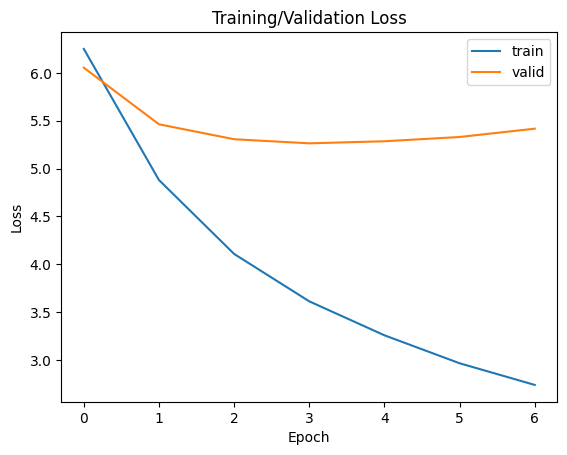

In [31]:
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation Loss")
plt.legend()
plt.show()

In [39]:
def vocab_itos(vocab):
    # torchtext Vocab: get_itos()
    if hasattr(vocab, "get_itos"):
        return vocab.get_itos()
    # fallback
    if hasattr(vocab, "itos"):
        return vocab.itos
    raise AttributeError("Не знайшов itos у vocab (ні get_itos(), ні itos).")

def vocab_stoi(vocab, token: str) -> int:
    # torchtext Vocab підтримує vocab[token]
    return vocab[token]

def tokenize_text(text: str, nlp, lower: bool, sos_token: str, eos_token: str, max_length: int):
    toks = [t.text for t in nlp.tokenizer(text)][:max_length]
    if lower:
        toks = [t.lower() for t in toks]
    return [sos_token] + toks + [eos_token]

In [40]:
def translate_with_attention(
    model,
    src_text: str,
    src_nlp,
    src_vocab,
    trg_vocab,
    sos_token: str,
    eos_token: str,
    lower: bool = True,
    max_length: int = 200,
    max_trg_len: int = 80,
    device="cpu",
    pad_index: int = 1,
):
    model.eval()

    # 1) tokenize + numericalize
    src_tokens = tokenize_text(src_text, src_nlp, lower, sos_token, eos_token, max_length)
    src_ids = [vocab_stoi(src_vocab, tok) for tok in src_tokens]

    src_tensor = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(1)  # [src_len, 1]
    src_mask = (src_tensor.squeeze(1) != pad_index).unsqueeze(0)  # [1, src_len] bool

    # 2) encoder
    with torch.no_grad():
        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)

    # 3) decode step-by-step
    trg_itos = vocab_itos(trg_vocab)
    sos_idx = vocab_stoi(trg_vocab, sos_token)
    eos_idx = vocab_stoi(trg_vocab, eos_token)

    input_idx = sos_idx
    pred_tokens = [sos_token]
    attn_matrix = []

    with torch.no_grad():
        for _ in range(max_trg_len):
            inp = torch.tensor([input_idx], dtype=torch.long, device=device)  # [batch=1]
            output, hidden, cell, attn = model.decoder(inp, hidden, cell, encoder_outputs, src_mask)
            # output: [1, trg_vocab]
            top1 = output.argmax(1).item()

            attn_matrix.append(attn.squeeze(0).detach().cpu())  # [src_len]

            pred_tokens.append(trg_itos[top1] if top1 < len(trg_itos) else "<oob>")
            input_idx = top1

            if top1 == eos_idx:
                break

    # attn: [trg_len, src_len]
    attn_matrix = torch.stack(attn_matrix, dim=0) if len(attn_matrix) else torch.empty(0)

    return src_tokens, pred_tokens, attn_matrix

In [42]:
def show_test_examples(
    model, test_data, en_nlp, en_vocab, pl_vocab,
    sos_token, eos_token, lower, max_length, device, pad_index,
    k=5, seed=42
):
    random.seed(seed)
    idxs = random.sample(range(len(test_data)), k)

    for i in idxs:
        ex = test_data[i]["translation"]
        src = ex["en"]
        gold = ex["pl"]

        src_tokens, pred_tokens, _ = translate_with_attention(
            model=model,
            src_text=src,
            src_nlp=en_nlp,
            src_vocab=en_vocab,
            trg_vocab=pl_vocab,
            sos_token=sos_token,
            eos_token=eos_token,
            lower=lower,
            max_length=max_length,
            max_trg_len=80,
            device=device,
            pad_index=pad_index,
        )

        pred = " ".join([t for t in pred_tokens[1:] if t not in [eos_token]])  # без <sos>, без <eos>

        print("SRC (EN):", src)
        print("GOLD(PL):", gold)
        print("PRED(PL):", pred)
        print("-" * 80)

# приклад виклику:
# show_test_examples(model, test_data, en_nlp, en_vocab, pl_vocab, sos_token, eos_token, lower, max_length, device, pad_index, k=5)

In [35]:
def plot_attention(src_tokens, pred_tokens, attn_matrix, max_src=50, max_trg=50):
    # обрізаємо, щоб картинка була читабельна
    src_tokens = src_tokens[:max_src]
    pred_tokens = pred_tokens[:max_trg]
    attn = attn_matrix[:len(pred_tokens)-1, :len(src_tokens)]  # -1 бо attn без <sos> кроку

    plt.figure(figsize=(min(12, 0.3*len(src_tokens)+2), min(8, 0.3*len(pred_tokens)+2)))
    plt.imshow(attn, aspect="auto")

    plt.xticks(range(len(src_tokens)), src_tokens, rotation=90)
    plt.yticks(range(len(pred_tokens)-1), pred_tokens[1:])  # без <sos>

    plt.xlabel("Source tokens")
    plt.ylabel("Predicted tokens")
    plt.title("Attention heatmap")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

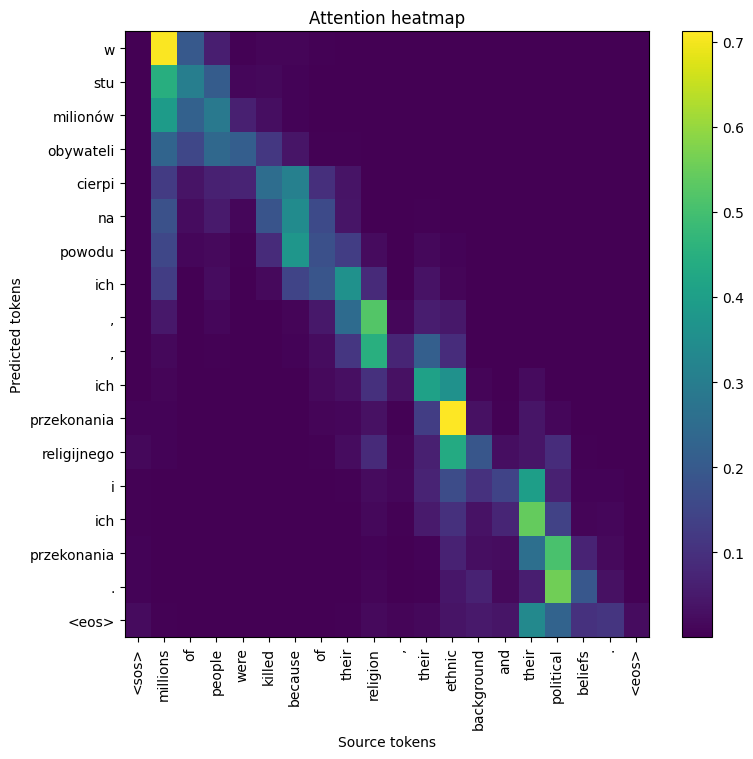

In [36]:
ex = test_data[0]["translation"]
src = ex["en"]

src_tokens, pred_tokens, attn_matrix = translate_with_attention(
    model=model,
    src_text=src,
    src_nlp=en_nlp,
    src_vocab=en_vocab,
    trg_vocab=pl_vocab,
    sos_token=sos_token,
    eos_token=eos_token,
    lower=lower,
    max_length=max_length,
    max_trg_len=80,
    device=device,
    pad_index=pad_index,
)

plot_attention(src_tokens, pred_tokens, attn_matrix)

Висновки.
Щось пішло не так. Модель перенавчається. З початку все йшло добре на валідаційних даних помилка зменшувалася, а потім навіть почала рости, підганяти під Train.
Teacher forcing допомагаж трейну а не допомагає валідаційнимданим. Взагалі був виклик для мене з тренуванням данох моделі, постійно не узгодувалися бібліотеки.
Щодо моделі оптимальна якість була на 5 епосі.